In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
#https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=a2vvHeFgVtCp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


In [2]:
from LSTMmodel import MultiLSTMModel, load_model

num_features = 5
input_size = num_features
OUT_STEPS = 16
lstm = MultiLSTMModel(input_size=input_size, lstm_units=32, out_steps=OUT_STEPS, num_features=num_features)
lstm = load_model(lstm, "appl_15min_8m_LSTM.pth")

In [15]:
from source.IB_connector import retrive_market_data

ticker = "GOOGL"
training_set_aapl = retrive_market_data([ticker], duration = "1 m", time_interval = "15 mins")
training_set = training_set_aapl[ticker]
training_set['Volume'] = training_set['Volume'].astype(float)
training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")
col_select = ['Open','High','Low','Close','Volume']
training_set = training_set[col_select]
training_set.dtypes
CLOSE_INDEX = col_select.index('Close')

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


In [16]:
from enviroments import TimeSeriesEnvFuturePredict
CLOSE_INDEX = 3
env = TimeSeriesEnvFuturePredict(data=training_set['Close'].values, lstm=lstm,lstm_data=training_set.values,device="cuda",
                                 train_std = training_set.std()[CLOSE_INDEX],train_mean= training_set.mean()[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

In [17]:
from rl_agent import load_dqn_agent, DQNAgent

agent = DQNAgent(observation_space=env.observation_space.shape[0], action_space=env.action_space.n)
load_dqn_agent(agent, "aapl_15min_norm.pth")

Model załadowany z aapl_15min_norm.pth


c:\programowanie\trade_opt\rl_agent.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device("cuda" if torch.cuda.is

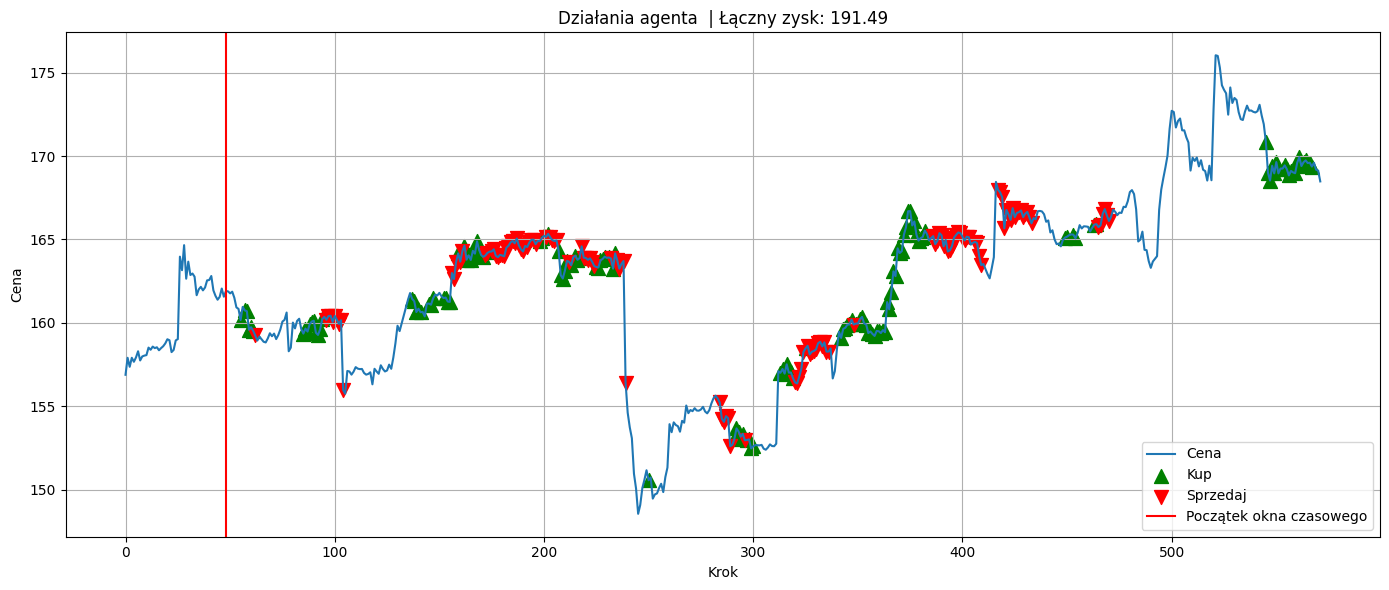

In [18]:
from eval_models import evaluate_steps, render_env

env.reset()
evaluate_steps(env, agent.target_model)
render_env(env, title_suffix="")